# Árbol de decisión

## 1. Obtención de los datos de entrada

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [5]:
import os

data_rute = os.path.join('Datasets', 'artists_billboard_fix3.csv')
artists_billboard = pd.read_csv(data_rute)

artists_billboard.shape

(635, 11)

## 2. Análisis exploratorio inicial

In [6]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


In [7]:
artists_billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

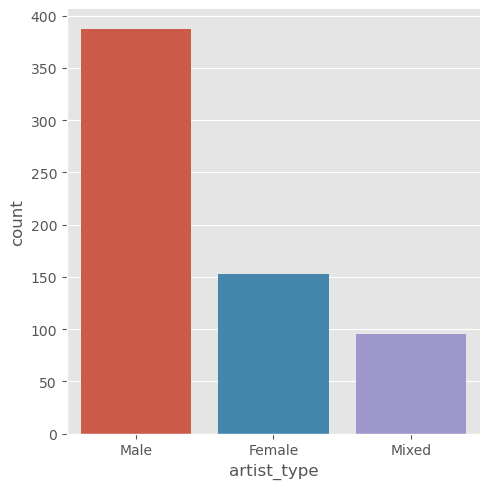

In [11]:
sns.catplot(x='artist_type', data=artists_billboard, kind='count')

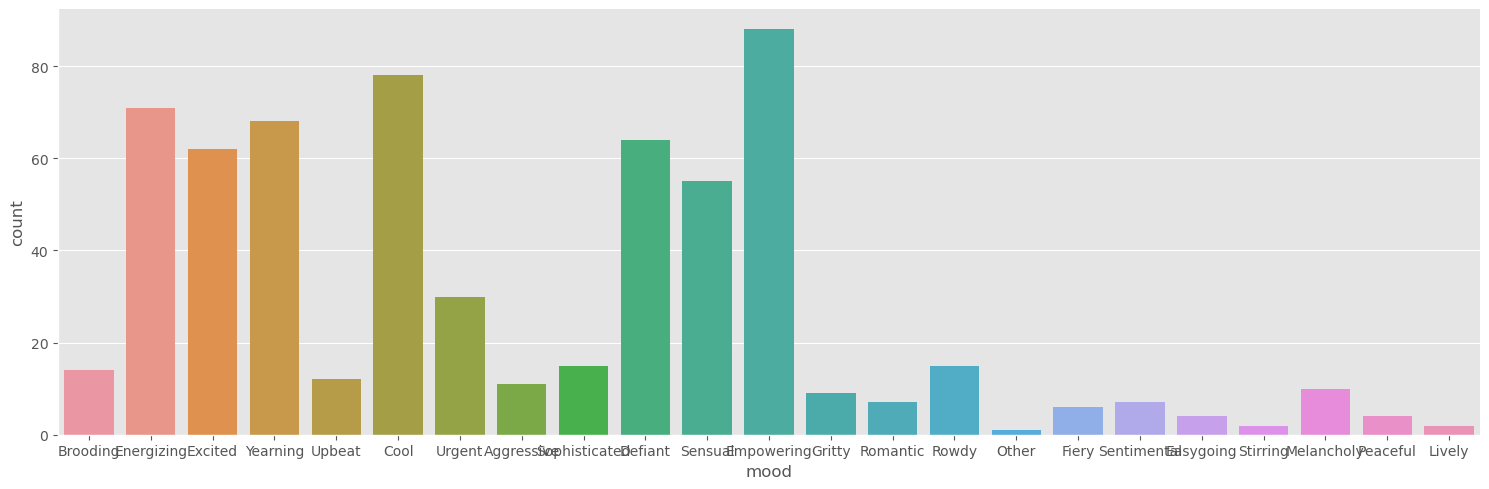

In [12]:
sns.catplot(x='mood', data=artists_billboard, kind='count', aspect=3)

AttributeError: 'numpy.int64' object has no attribute 'startswith'

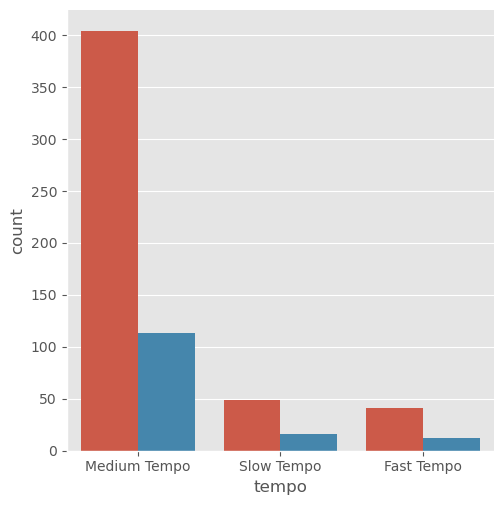

In [16]:
sns.catplot(x='tempo', data=artists_billboard, hue='top', kind='count')

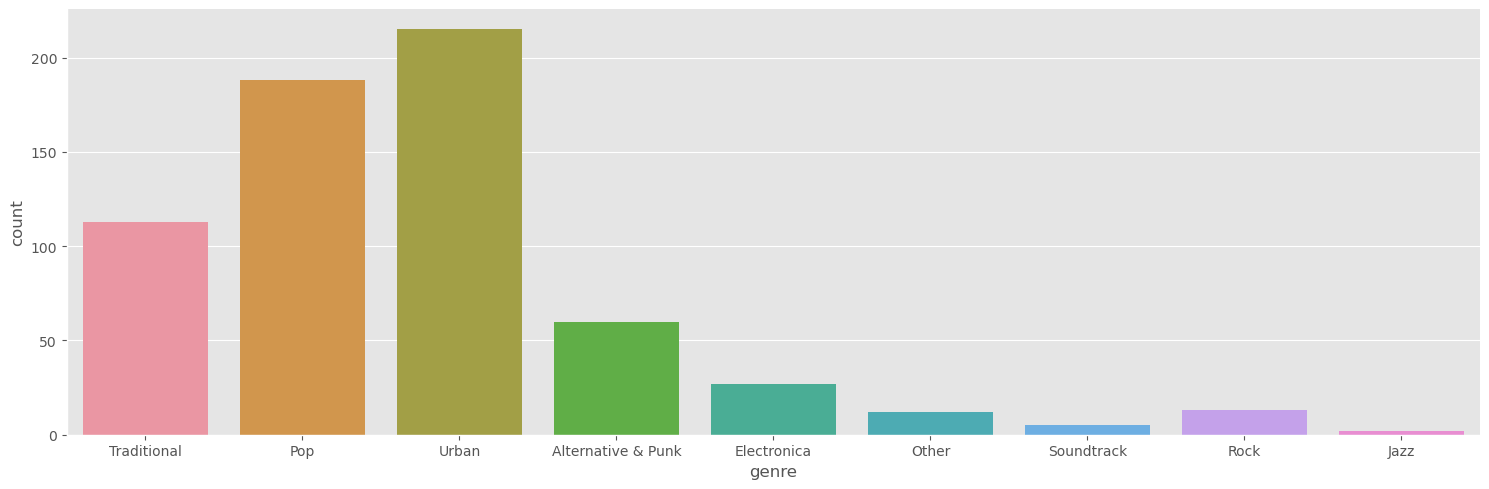

In [17]:
sns.catplot(x='genre', data=artists_billboard, kind='count', aspect=3)

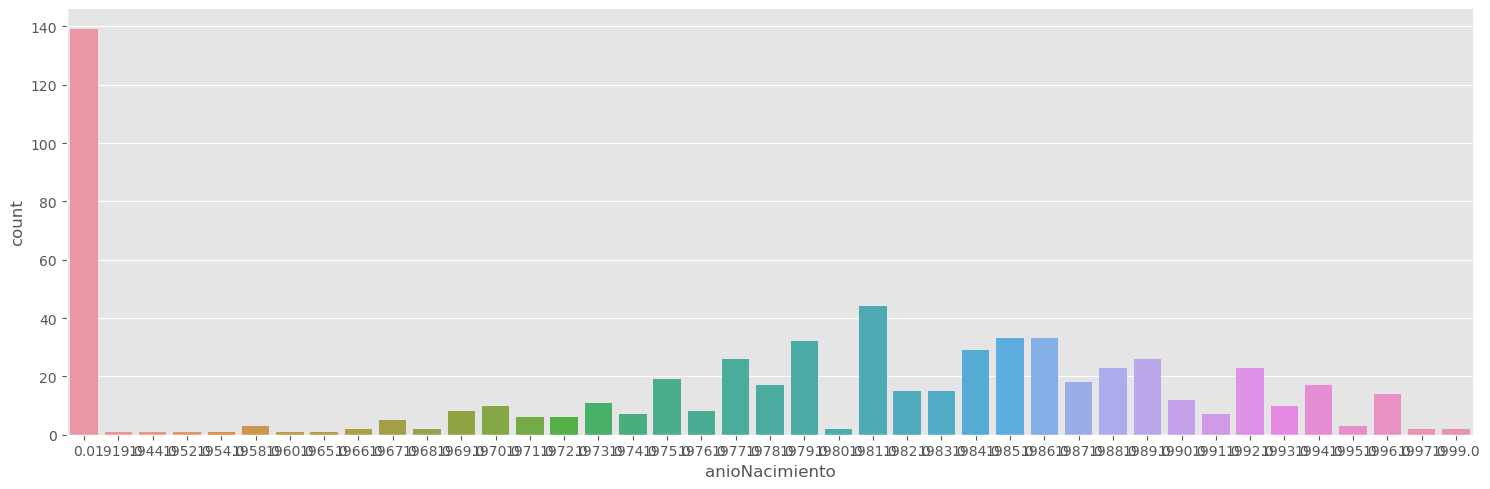

In [18]:
sns.catplot(x='anioNacimiento', data=artists_billboard, kind='count', aspect=3)

## 3. Balanceo de datos

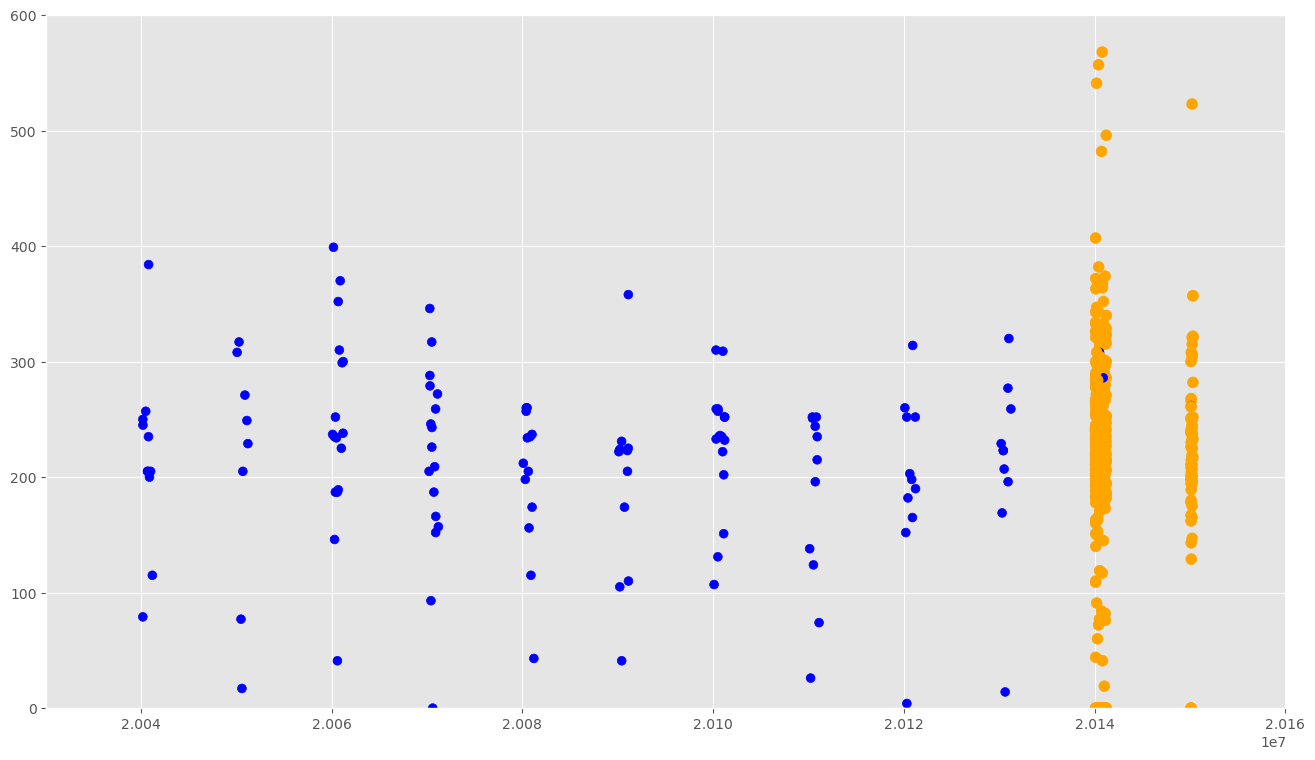

In [19]:
f1 = artists_billboard['chart_date'].values
f2 = artists_billboard['durationSeg'].values

colores = ['orange', 'blue']
tamanios = [60, 40]

asignar = []
asignar2 = []
for index, row in artists_billboard.iterrows():
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])

plt.scatter(f1, f2, c=asignar, s=asignar2)
plt.axis([20030101, 20160101, 0, 600])
plt.show()

### 3.1. Preparamos los datos

In [20]:
def edad_fix(anio):
    if anio == 0:
        return None
    return anio

artists_billboard['anioNacimiento'] = artists_billboard.apply(
    lambda x: edad_fix(x['anioNacimiento']),
    axis=1
)

In [22]:
def calcula_edad(anio, cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio == 0.0:
        return None
    return int(momento) - anio

artists_billboard['edad_en_billboard'] = artists_billboard.apply(
    lambda x: calcula_edad(x['anioNacimiento'], x['chart_date']),
    axis=1
)

In [23]:
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad promedio: " + str(age_avg))
print("Desviación Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg - age_std)))

Edad promedio: 30.10282258064516
Desviación Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 21


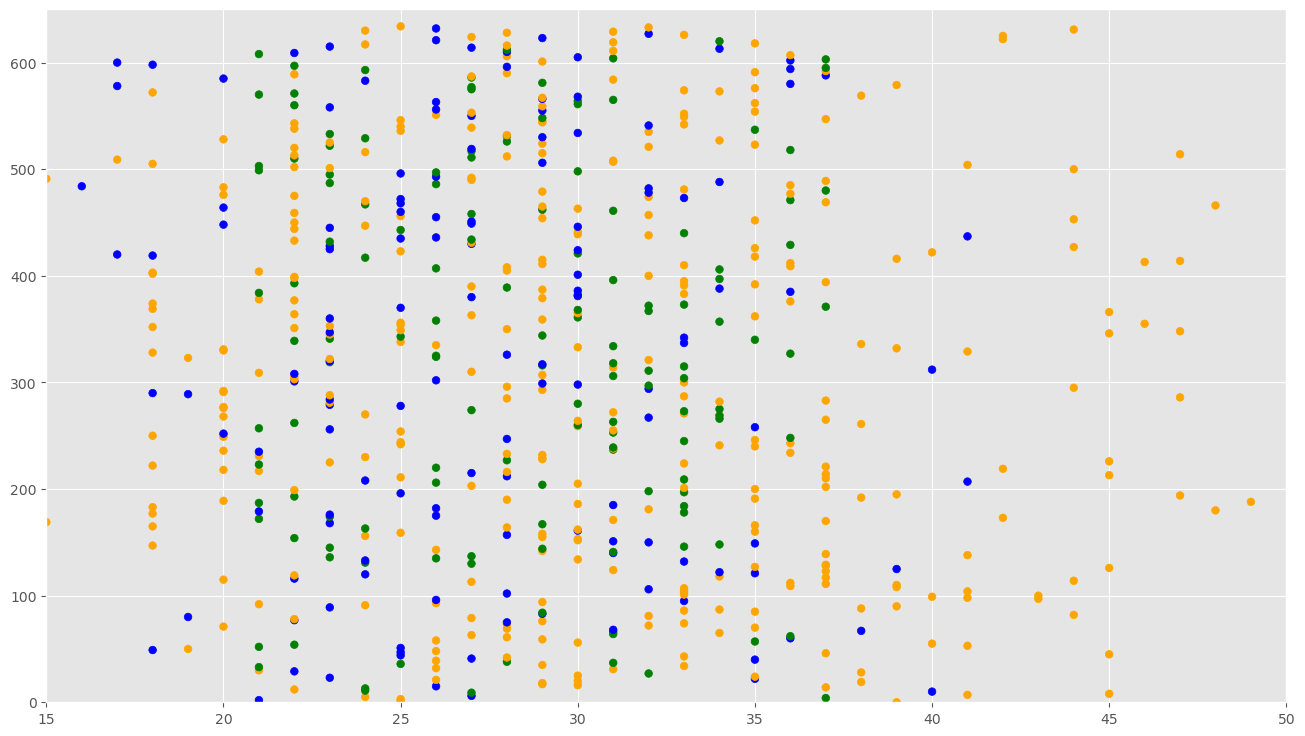

In [24]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index

colores = ['orange', 'blue', 'green']

asignar = []
for index, row in artists_billboard.iterrows():
    if (conValoresNulos[index]):
        asignar.append(colores[2])
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15, 50, 0, 650])
plt.show()